In [347]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import seaborn as sns
from sklearn.linear_model import LinearRegression
from Bio import SeqIO
from itertools import chain
import pyranges as pr

In [210]:
plt.rcParams["figure.figsize"] = (12,8)
sns.set()

In [45]:
res_df = pd.read_csv('zscores_by_position.csv', index_col=0)

In [46]:
res_df.head()

,Start,End,Start_r,End_r,Mean_Z-Score,Threshold,Sequence_id
0,0,10,0.000000,0.000034,0.0,50,AY394995.1
1,10,20,0.000336,0.000370,0.0,50,AY394995.1
2,20,30,0.000672,0.000706,0.0,50,AY394995.1
3,30,40,0.001008,0.001041,0.0,50,AY394995.1
4,40,50,0.001344,0.001377,0.0,50,AY394995.1


In [49]:
res_df.Threshold.unique()

array([ 50, 150, 300])

In [120]:
sequences_df = pd.read_csv('all_sequences.csv', sep=' ')

In [121]:
sequences_df['Date'] = sequences_df.apply(
    lambda row: dt.date(
        year=int(row['YEAR']),
        month=int(1 if np.isnan(row['MONTH']) else row['MONTH']),
        day=int(1 if np.isnan(row['DAY']) else row['DAY']),
    ),
    axis=1
)

In [122]:
sequences_df.head()

,Virus_name,Species,Sample_location,Accession_no.,YEAR,MONTH,DAY,Length,Date
0,RpShaanxi2011,R_pusillus,Shaanxi,JX993987,2011,9.0,NaN,29484.0,2011-09-01
1,HuB2013,R_sinicus,Hubei,KJ473814,2013,4.0,NaN,29658.0,2013-04-01
2,279_2005,R_macrotis,Hubei,DQ648857,2004,11.0,NaN,29741.0,2004-11-01
3,Rm1,R_macrotis,Hubei,DQ412043,2004,11.0,NaN,29749.0,2004-11-01
4,JL2012,R_ferrumequinum,Jilin,KJ473811,2012,10.0,NaN,29037.0,2012-10-01


# Visualizations #1

In [53]:
mean_high_zscore_length = res_df[res_df.Threshold==300].groupby('Sequence_id').apply(
    lambda df: 10*df[df['Mean_Z-Score']>0].shape[0]
)

In [62]:
plot_df = sequences_df.copy()
plot_df['h_zscore_length'] = (plot_df['Accession_no.']+ '.1').map(mean_high_zscore_length.to_dict())
plot_df.head()

,Virus_name,Species,Sample_location,Accession_no.,YEAR,MONTH,DAY,Date,h_zscore_length
0,RpShaanxi2011,R_pusillus,Shaanxi,JX993987,2011,9.0,NaN,2011-09-01,470.0
1,HuB2013,R_sinicus,Hubei,KJ473814,2013,4.0,NaN,2013-04-01,380.0
2,279_2005,R_macrotis,Hubei,DQ648857,2004,11.0,NaN,2004-11-01,330.0
3,Rm1,R_macrotis,Hubei,DQ412043,2004,11.0,NaN,2004-11-01,360.0
4,JL2012,R_ferrumequinum,Jilin,KJ473811,2012,10.0,NaN,2012-10-01,300.0


In [100]:
model = LinearRegression()
model = model.fit(
    (plot_df.Date - plot_df.Date.min()).to_numpy().reshape(-1, 1).astype('timedelta64[D]')[
        plot_df.h_zscore_length.notna()
    ],
    plot_df.h_zscore_length[plot_df.h_zscore_length.notna()]
)


In [112]:
x = np.array([0, plot_df.Date.max()-plot_df.Date.min()]).astype('timedelta64[D]').astype(int)

In [114]:
y = model.predict(x.reshape(-1, 1))

In [95]:
(plot_df.Date - plot_df.Date.min()).to_numpy().astype('timedelta64[D]').astype(int)

array([3530, 4108, 1035, 1035, 3926, 4291, 4108, 4322, 3652, 1035, 3957,
       1065, 3913, 4124, 4219, 4219, 5357, 4679, 5036, 3913, 3393, 3730,
       3896, 5357, 4514, 5357, 3913, 4124, 4124, 4124, 1704, 5357, 3256,
       4018, 4018,    0, 4160, 4160, 3652, 5387, 3287, 3591, 3652, 1143,
       1171, 1150, 1296, 1358, 1445, 1761, 1761, 1891, 2144, 1960, 1506,
       1506, 5510, 4929, 6543, 2099, 2282, 4222, 5479, 5479, 5479, 5479,
       5479, 6268])

In [398]:
# fig = px.scatter(plot_df, x="Date", y="h_zscore_length", hover_data=['Virus_name'], )
# fig.add_shape(type="line",
#               x0=plot_df.Date.min(), 
#               y0=y[0], 
#               x1=plot_df.Date.max(), 
#               y1=y[1],
#              )
# # fig.update(layout_xaxis_range=[0,620])
# fig.show()

# Attempt #2 

In [133]:
zdna_ranges_df = pd.read_csv('zscores_merged.csv', index_col=0)

In [134]:
zdna_ranges_df.head()

,Chromosome,Start,End,Threshold,Sequence_id
0,chr1,92,110,50,AY394995.1
1,chr1,221,237,50,AY394995.1
2,chr1,279,295,50,AY394995.1
3,chr1,322,338,50,AY394995.1
4,chr1,368,385,50,AY394995.1


In [399]:
# for threshold, group_df in zdna_ranges_df.groupby('Threshold'):
#     group_df['Length'] = group_df.End-group_df.Start
#     stats_df = group_df.groupby('Sequence_id').agg({'Length': sum})
#     stats_df.index = stats_df.index.str[:-2]
#     plot_df = sequences_df.copy()
#     plot_df['High_Zscore_Length'] = plot_df['Accession_no.'].map(stats_df['Length'].to_dict())

#     # Trend line
#     model = LinearRegression()
#     model = model.fit(
#         (plot_df.Date - plot_df.Date.min()).to_numpy().reshape(-1, 1).astype('timedelta64[D]')[
#             plot_df.High_Zscore_Length.notna()
#         ],
#         plot_df.High_Zscore_Length[plot_df.High_Zscore_Length.notna()]
#     )
#     x = np.array([0, plot_df.Date.max()-plot_df.Date.min()]).astype('timedelta64[D]').astype(int)
#     y = model.predict(x.reshape(-1, 1))
#     print(model.coef_)
#     fig = px.scatter(
#         plot_df, x="Date", y="High_Zscore_Length", hover_data=['Virus_name'],
#         title=f'Z-Score Threshold: {threshold}, Trend slope: {model.coef_[0]:.4f}'
#     )
    
    
#     fig.add_shape(type="line",
#               x0=plot_df.Date.min(), 
#               y0=y[0], 
#               x1=plot_df.Date.max(), 
#               y1=y[1],
#              )
#     fig.update_layout(yaxis_range=[0,plot_df['High_Zscore_Length'].max()*1.1])
#     fig.show()


# SARS-1, MERS, SARS-COV-2 reference, delta, omicron comparison

In [178]:
sequences_metadata = pd.read_csv('data/sars_mers/metadata.csv')
sequences_metadata

,ID,Strain,Description
0,MZ359841.1,Delta,Severe acute respiratory syndrome coronavirus...
1,KU740200.1,MERS,Middle East respiratory syndrome-related coro...
2,OL869974.1,Omicron,Severe acute respiratory syndrome coronavirus...
3,NC_045512.2,Reference SARS-COV-2,Severe acute respiratory syndrome coronavirus...
4,NC_004718.3,SARS-1,SARS coronavirus Tor2


In [179]:
sequences_dict = sequences_metadata.set_index('ID')['Strain'].to_dict()
sequences_dict

{'MZ359841.1': 'Delta',
 'KU740200.1': 'MERS',
 'OL869974.1': 'Omicron',
 'NC_045512.2': 'Reference SARS-COV-2',
 'NC_004718.3': 'SARS-1'}

In [191]:
plots_data_df = pd.read_csv('sars_mers_by_position.csv', index_col=0)
plots_data_df['Strain'] = plots_data_df['Sequence_id'].map(sequences_dict)
plots_data_df.head()

,Start,End,Start_r,End_r,Mean_Z-Score,Median_Z-Score,Threshold,Sequence_id,Strain
0,0,10,0.000000,0.000336,0.0,0.0,50,MZ359841.1,Delta
1,10,20,0.000336,0.000671,0.0,0.0,50,MZ359841.1,Delta
2,20,30,0.000671,0.001007,0.0,0.0,50,MZ359841.1,Delta
3,30,40,0.001007,0.001343,0.0,0.0,50,MZ359841.1,Delta
4,40,50,0.001343,0.001678,0.0,0.0,50,MZ359841.1,Delta


# Threshold = 50

In [428]:
# fig = px.line(
#     plots_data_df[(plots_data_df['Threshold']==50)],
#     x="Start", y="Mean_Z-Score",
#     hover_data=['Strain'],
#     color='Strain',
# )
# fig.show()

In [429]:
# plots_coverage_df = pd.read_csv('sars_mers_coverage.csv', index_col=0)
# plots_coverage_df['Strain'] = plots_coverage_df['Sequence_id'].map(sequences_dict)
# plots_coverage_df['Length'] = plots_coverage_df['End'] - plots_coverage_df['Start']
# plots_coverage_df.head()

In [253]:
agg_df = plots_coverage_df.groupby(['Strain', 'Threshold']).agg({'Length': sum})
agg_df

Length
Strain               Threshold        
Delta                50           1045
                     150           426
                     300           209
MERS                 50           1355
                     150           405
                     300           259
Omicron              50           1018
                     150           409
                     300           209
Reference SARS-COV-2 50           1066
                     150           420
                     300           209
SARS-1               50           1396
                     150           430
                     300           265

In [254]:
agg_50_df = plots_coverage_df[plots_coverage_df['Threshold'] == 50].groupby(['Strain']).agg({'Length': sum})
agg_50_df['Order'] = agg_50_df.index.map(
    {'SARS-1': 0, 'MERS': 1, 'Reference SARS-COV-2': 2, 'Delta': 3, 'Omicron':4}
)
agg_50_df = agg_50_df.sort_values(['Order'], ascending=True)
agg_50_df

,Length,Order
Strain,,
SARS-1,1396,0
MERS,1355,1
Reference SARS-COV-2,1066,2
Delta,1045,3
Omicron,1018,4


In [561]:
agg_300_df = plots_coverage_df[plots_coverage_df['Threshold'] == 300].groupby(['Strain']).agg(
    {'Length': sum, 'Strain': 'count' }
)
agg_300_df['Order'] = agg_300_df.index.map(
    {'SARS-1': 0, 'MERS': 1, 'Reference SARS-COV-2': 2, 'Delta': 3, 'Omicron':4}
)
agg_300_df = agg_300_df.sort_values(['Order'], ascending=True)
agg_300_df

,Length,Strain,Order
Strain,,,
SARS-1,265,14,0
MERS,259,17,1
Reference SARS-COV-2,209,13,2
Delta,209,13,3
Omicron,209,13,4


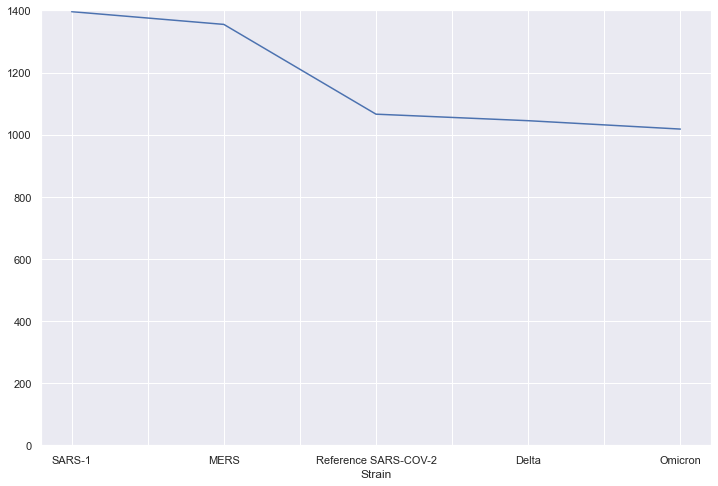

In [212]:
fig = agg_50_df['Length'].plot(ylim=[0,1400])

# Plot annotated sequences

In [220]:
gene_annotations_df = pd.read_csv('data/sars_mers/reference_genes.csv', sep='\t')


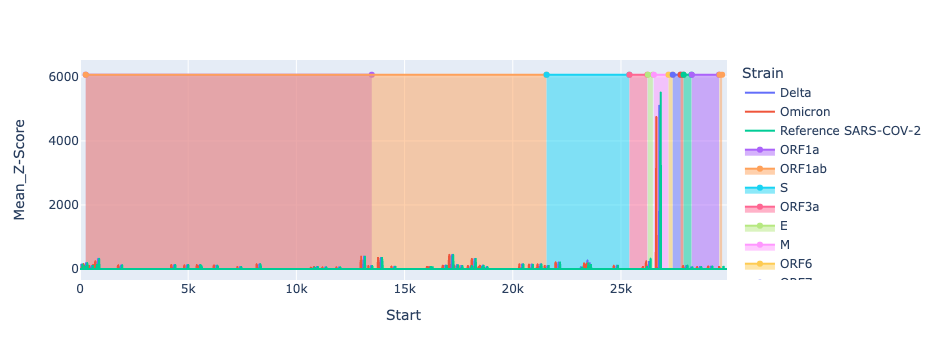

In [219]:

p_df = plots_data_df[(plots_data_df['Threshold']==50) & (plots_data_df['Strain'] != 'SARS-1') & 
                    (plots_data_df['Strain'] != 'MERS')
                    ]

fig = px.line(
    p_df,
    x="Start", y="Mean_Z-Score",
    hover_data=['Strain'],
    color='Strain',
)
max_score = p_df['Mean_Z-Score'].max()
MAX_Y_VALUE = max_score
y = 1.1
for _, row in gene_annotations_df.iterrows():
    fig.add_trace(
        go.Scatter(
            x=[row.thickStart, row.thickEnd],
            y=[MAX_Y_VALUE*y, MAX_Y_VALUE*y],
            name=row['name'],
            fill='tozeroy',
            opacity=0.01
        )
    )

fig.show()

# fig.write_html("./reference_annotated_zscores.html")

# Plot aligned sequences

In [222]:
aligned_sequences = {record.id: record.seq for record in SeqIO.parse(
    'data/sars_mers/3cov2_variants_alignment.fasta', "fasta"
)}

In [233]:
p_df = plots_data_df[
    (plots_data_df['Threshold']==50) & (plots_data_df['Strain'] != 'SARS-1') & 
    (plots_data_df['Strain'] != 'MERS')
].copy()

offset = p_df.apply(
#     lambda row: print(row) or 1/0,
    lambda row: aligned_sequences[row['Sequence_id']][:row['Start']].count('-'),
    axis=1
)
p_df['Start']+=offset
p_df['End']+=offset
p_df.head()

,Start,End,Start_r,End_r,Mean_Z-Score,Median_Z-Score,Threshold,Sequence_id,Strain
0,0,10,0.000000,0.000336,0.0,0.0,50,MZ359841.1,Delta
1,20,30,0.000336,0.000671,0.0,0.0,50,MZ359841.1,Delta
2,40,50,0.000671,0.001007,0.0,0.0,50,MZ359841.1,Delta
3,60,70,0.001007,0.001343,0.0,0.0,50,MZ359841.1,Delta
4,80,90,0.001343,0.001678,0.0,0.0,50,MZ359841.1,Delta


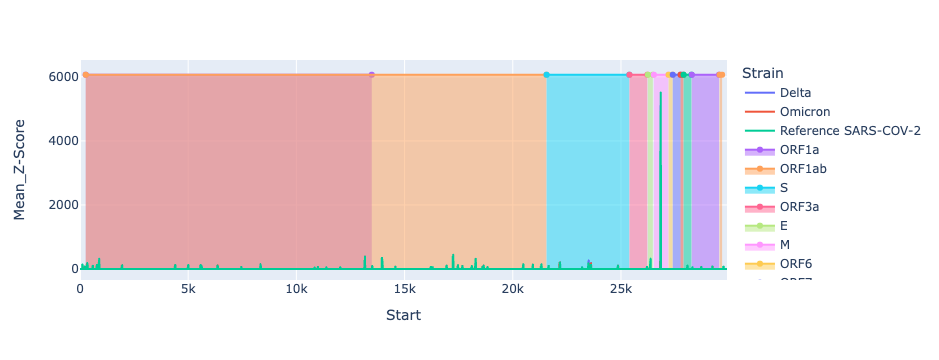

In [238]:
fig = px.line(
    p_df,
    x="Start", y="Mean_Z-Score",
    hover_data=['Strain'],
    color='Strain',
)
max_score = p_df['Mean_Z-Score'].max()
MAX_Y_VALUE = max_score
y = 1.1
for _, row in gene_annotations_df.iterrows():
    fig.add_trace(
        go.Scatter(
            x=[row.thickStart, row.thickEnd],
            y=[MAX_Y_VALUE*y, MAX_Y_VALUE*y],
            name=row['name'],
            fill='tozeroy',
            opacity=0.01
        )
    )

fig.show()

In [246]:
for _id, sequence in aligned_sequences.items():
    print(f'{sequences_dict[_id]:20s}', sequence[26780:26875])

Omicron              CTTGTAGGCTTGATGTGGCTCAGCTACTTCATTGCTTCTTTCAGACTGTTTGCGCGTACGCGTTCCATGTGGTCATTCAATCCAGAAACTAACAT
Reference SARS-COV-2 CTTGTAGGCTTGATGTGGCTCAGCTACTTCATTGCTTCTTTCAGACTGTTTGCGCGTACGCGTTCCATGTGGTCATTCAATCCAGAAACTAACAT
Delta                CTTGTAGGCTTGATGTGGCTCAGCTACTTCATTGCTTCTTTCAGACTGTTTGCGCGTACGCGTTCCATGTGGTCATTCAATCCAGAAACTAACAT


In [255]:
sequences_dict

{'MZ359841.1': 'Delta',
 'KU740200.1': 'MERS',
 'OL869974.1': 'Omicron',
 'NC_045512.2': 'Reference SARS-COV-2',
 'NC_004718.3': 'SARS-1'}

In [260]:
reference_seq = aligned_sequences['NC_045512.2']
omicron_seq = aligned_sequences['OL869974.1']
delta_seq = aligned_sequences['MZ359841.1']

# Display High-ZScore regions

In [305]:
raw_p_df = plots_coverage_df[
    (plots_coverage_df['Threshold']==50) & (plots_coverage_df['Strain'] != 'SARS-1') & 
    (plots_coverage_df['Strain'] != 'MERS')
].copy()

# Y_dict = {'SARS-1': 0, 'MERS': 5, 'Reference SARS-COV-2': 10, 'Delta': 15, 'Omicron':20}

Y_dict = {'Reference SARS-COV-2': 0, 'Delta': 5, 'Omicron':10}

p_df = pd.DataFrame(
    chain(
            [
                {
                    'X': 0,
                    'Y': Y_dict[strain],
                    'Strain': strain,
                } for strain in [
                 'Reference SARS-COV-2', 'Delta', 'Omicron'   
                ]
            ],
            *raw_p_df.apply(
            lambda row: [
                {
                    'X': row['Start'] - 1,
                    'Y': Y_dict[row['Strain']],
                    'Strain': row['Strain'],
                },
                {
                    'X': row['Start'],
                    'Y': Y_dict[row['Strain']] + 1,
                    'Strain': row['Strain'],
                },
                {
                    'X': row['End'],
                    'Y': Y_dict[row['Strain']] + 1,
                    'Strain': row['Strain'],
                },
                {
                    'X': row['End'] + 1,
                    'Y': Y_dict[row['Strain']],
                    'Strain': row['Strain'],
                },
            
            ],
            axis=1
         )
         )
)
p_df['ID'] = p_df['Strain'].map({value:key for key, value in sequences_dict.items()})
offset = p_df.apply(
#     lambda row: print(row) or 1/0,
    lambda row: aligned_sequences[row['ID']][:row['X']].count('-'),
    axis=1
)
p_df['X']+=offset
p_df.head()

,X,Y,Strain,ID
0,0,0,Reference SARS-COV-2,NC_045512.2
1,0,5,Delta,MZ359841.1
2,0,10,Omicron,OL869974.1
3,109,5,Delta,MZ359841.1
4,110,6,Delta,MZ359841.1


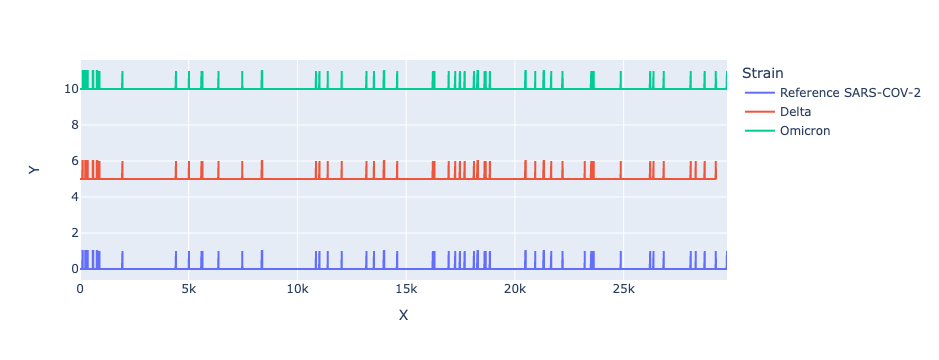

In [306]:
# fig = px.timeline(p_df.iloc[:100,:], x_start="Start", x_end="End", y="Strain")
# # fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
# # fig.layout.xaxis.type = 'linear'
fig = px.line(p_df, x='X', y='Y', color='Strain')

fig.show()

# Display mutations

In [321]:
changes_df = pd.DataFrame(
[
{
    'X': pos,
    'Type': 'Deletion' if new_base=='-' else 'Change',
    'Old_base': ref_base,
    'New_base': new_base,
    'Target_strain': 'Omicron',
}
    for pos, (ref_base, new_base) in
    enumerate(zip(
        aligned_sequences['NC_045512.2'],
        aligned_sequences['OL869974.1'],
    ))
    if new_base!=ref_base

]
)
changes_df.head()

,X,Type,Old_base,New_base,Target_strain
0,0,Deletion,A,-,Omicron
1,1,Deletion,T,-,Omicron
2,2,Deletion,T,-,Omicron
3,3,Deletion,A,-,Omicron
4,4,Deletion,A,-,Omicron


In [322]:
changes_df.Type.unique()

array(['Deletion', 'Change'], dtype=object)

In [329]:

fig = px.line(p_df, x='X', y='Y', color='Strain')

MAX_Y_VALUE = 11
for _, row in gene_annotations_df.iterrows():
    fig.add_trace(
        go.Scatter(
            x=[row.thickStart, row.thickEnd],
            y=[MAX_Y_VALUE*y, MAX_Y_VALUE*y],
            name=row['name'],
            fill='tozeroy',
            opacity=0.01
        )
    )
    
    
# fig.show()


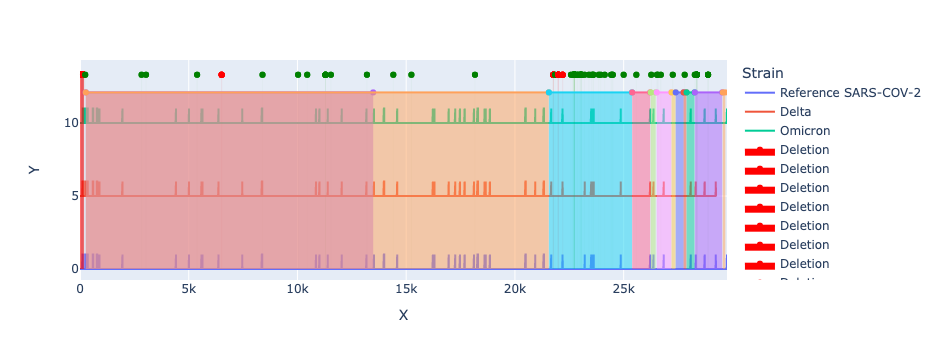

In [331]:

fig = px.line(p_df, x='X', y='Y', color='Strain')

MAX_Y_VALUE = 11
for _, row in changes_df.iterrows():
    fig.add_trace(
        go.Scatter(
            x=[row.X, row.X+1],
            y=[MAX_Y_VALUE*y*1.1, MAX_Y_VALUE*y*1.1],
            name=row['Type'],
            fill='tozeroy',
            opacity=0.01,
            fillcolor='green' if row.Type == 'Change' else 'red',
            marker={'color': 'green' if row.Type == 'Change' else 'red'}
#             hoverinfo='all'
        )
    )
    
for _, row in gene_annotations_df.iterrows():
    fig.add_trace(
        go.Scatter(
            x=[row.thickStart, row.thickEnd],
            y=[MAX_Y_VALUE*y, MAX_Y_VALUE*y],
            name=row['name'],
            fill='tozeroy',
            opacity=0.01
        )
    )
    
    
    
fig.show()


# Analyse disappearing ZDNA regions

In [368]:
THRESHOLD = 50

# z_locations_50_df = plots_data_df[
#     (plots_data_df['Threshold']==50) & ((plots_data_df['Strain'] == 'Reference SARS-COV-2') | 
#     (plots_data_df['Strain'] == 'Omicron')) & (plots_data_df['Mean_Z-Score']>=50)
# ].copy().reset_index(drop=True)

z_locations_o = pd.read_csv('zscores/OL869974.1.csv', index_col=0)
z_locations_r = pd.read_csv('zscores/NC_045512.2.csv', index_col=0)
z_locations_o['Sequence_id'] = 'OL869974.1'
z_locations_r['Sequence_id'] = 'NC_045512.2'
z_locations_o['Strain'] = 'Omicron'
z_locations_r['Strain'] = 'Reference'

z_locations_o = z_locations_o[z_locations_o['Z-Score'] >= THRESHOLD].reset_index(drop=True)
z_locations_r = z_locations_r[z_locations_r['Z-Score'] >= THRESHOLD].reset_index(drop=True)



base_offset = {
'OL869974.1': 177,
'NC_045512.2': 0,
}


z_locations_o['Start'] += z_locations_o.apply(
    lambda row: (
        aligned_sequences[row['Sequence_id']][base_offset[row['Sequence_id']]:row['Start']].count('-')
        + base_offset[row['Sequence_id']]
      ),
    axis=1
)
z_locations_o['End'] += z_locations_o.apply(
    lambda row: (
        aligned_sequences[row['Sequence_id']][base_offset[row['Sequence_id']]:row['End']].count('-')
        + base_offset[row['Sequence_id']]
      ),
    axis=1
)




# z_locations_50_df['Offset_s'] = z_locations_50_df.apply(
#     lambda row: (
#         aligned_sequences[row['Sequence_id']][base_offset[row['Sequence_id']]:row['Start']].count('-')
#         + base_offset[row['Sequence_id']]
#       ),
#     axis=1
# )
# z_locations_50_df['Offset_e'] = z_locations_50_df.apply(
#     lambda row: (
#         aligned_sequences[row['Sequence_id']][base_offset[row['Sequence_id']]:row['End']].count('-')
#         + base_offset[row['Sequence_id']]
#       ),
#     axis=1
# )
# z_locations_50_df['Start'] += z_locations_50_df['Offset_s']
# z_locations_50_df['End'] += z_locations_50_df['Offset_e']
# z_locations_50_df['Chromosome'] = 'chr1'
# z_locations_50_df.iloc[:20]
z_locations_o

,Start,End,nu-1,nu-2,nu-3,Z-Score,Sequence,Conformation,Sequence_id,Strain
0,241,253,12,23.973,38.426,54.40138,tgtccgggtgtg,ASASASASASAS,OL869974.1,Omicron
1,295,309,14,23.970,33.412,54.55126,gaaaacacacgtcc,SASASASASASASA,OL869974.1,Omicron
2,297,309,12,23.702,33.260,69.76203,aaacacacgtcc,SASASASASASA,OL869974.1,Omicron
3,298,310,12,24.063,31.341,50.19928,aacacacgtcca,ASASASASASAS,OL869974.1,Omicron
4,299,311,12,23.713,27.294,69.05027,acacacgtccaa,SASASASASASA,OL869974.1,Omicron
...,...,...,...,...,...,...,...,...,...,...
302,29226,29240,14,23.536,34.824,81.60069,cgcgcattggcatg,ASASASASASASAS,OL869974.1,Omicron
303,29733,29745,12,23.718,25.299,68.73659,cgaggccacgcg,ASASASASASAS,OL869974.1,Omicron
304,29735,29747,12,23.613,26.739,75.85403,aggccacgcgga,SAASASASASAS,OL869974.1,Omicron
305,29737,29749,12,23.820,26.992,62.54546,gccacgcggagt,ASASASASSASA,OL869974.1,Omicron


In [369]:
z_locations_o[~z_locations_o['Sequence'].isin(z_locations_r['Sequence'])]

,Start,End,nu-1,nu-2,nu-3,Z-Score,Sequence,Conformation,Sequence_id,Strain
0,241,253,12,23.973,38.426,54.40138,tgtccgggtgtg,ASASASASASAS,OL869974.1,Omicron
253,23601,23617,16,23.310,39.609,101.59970,ctcatcggcgggcacg,ASASASASASASASAS,OL869974.1,Omicron
254,23602,23618,16,22.670,36.035,195.22600,tcatcggcgggcacgt,SASASASASASASASA,OL869974.1,Omicron
255,23603,23619,16,22.947,41.051,146.21110,catcggcgggcacgta,ASASASASASASASAS,OL869974.1,Omicron
256,23604,23618,14,22.430,37.417,252.83610,atcggcgggcacgt,SASASASASASASA,OL869974.1,Omicron


In [370]:
z_locations_r[~z_locations_r['Sequence'].isin(z_locations_o['Sequence'])]

,Start,End,nu-1,nu-2,nu-3,Z-Score,Sequence,Conformation,Sequence_id,Strain
0,110,126,16,22.831,42.411,164.82620,cttagtgcactcacgc,SASASASASASASASA,NC_045512.2,Reference
1,111,127,16,23.499,40.931,84.60857,ttagtgcactcacgca,ASASASASASASASAS,NC_045512.2,Reference
2,112,126,14,22.635,43.205,202.57790,tagtgcactcacgc,SASASASASASASA,NC_045512.2,Reference
3,113,127,14,23.294,40.559,103.19680,agtgcactcacgca,ASASASASASASAS,NC_045512.2,Reference
4,114,126,12,22.433,40.737,251.82890,gtgcactcacgc,SASASASASASA,NC_045512.2,Reference
5,115,127,12,23.148,38.512,119.27680,tgcactcacgca,ASASASASASAS,NC_045512.2,Reference
6,116,128,12,23.550,35.604,80.56266,gcactcacgcag,SASASASASASA,NC_045512.2,Reference
7,237,253,16,23.782,41.073,64.76655,gtttcgtccgggtgtg,SAASASASASASASAS,NC_045512.2,Reference
8,239,253,14,23.565,41.017,79.40120,ttcgtccgggtgtg,ASASASASASASAS,NC_045512.2,Reference
9,241,253,12,23.370,40.776,95.76871,cgtccgggtgtg,ASASASASASAS,NC_045512.2,Reference


In [380]:
z_locations = pd.concat([z_locations_o, z_locations_r])
z_locations = z_locations.drop_duplicates(['Z-Score', 'Sequence'], keep=False)
z_locations

,Start,End,nu-1,nu-2,nu-3,Z-Score,Sequence,Conformation,Sequence_id,Strain
0,241,253,12,23.973,38.426,54.40138,tgtccgggtgtg,ASASASASASAS,OL869974.1,Omicron
253,23601,23617,16,23.310,39.609,101.59970,ctcatcggcgggcacg,ASASASASASASASAS,OL869974.1,Omicron
254,23602,23618,16,22.670,36.035,195.22600,tcatcggcgggcacgt,SASASASASASASASA,OL869974.1,Omicron
255,23603,23619,16,22.947,41.051,146.21110,catcggcgggcacgta,ASASASASASASASAS,OL869974.1,Omicron
256,23604,23618,14,22.430,37.417,252.83610,atcggcgggcacgt,SASASASASASASA,OL869974.1,Omicron
0,110,126,16,22.831,42.411,164.82620,cttagtgcactcacgc,SASASASASASASASA,NC_045512.2,Reference
1,111,127,16,23.499,40.931,84.60857,ttagtgcactcacgca,ASASASASASASASAS,NC_045512.2,Reference
2,112,126,14,22.635,43.205,202.57790,tagtgcactcacgc,SASASASASASASA,NC_045512.2,Reference
3,113,127,14,23.294,40.559,103.19680,agtgcactcacgca,ASASASASASASAS,NC_045512.2,Reference
4,114,126,12,22.433,40.737,251.82890,gtgcactcacgc,SASASASASASA,NC_045512.2,Reference


In [394]:
changes_df[(changes_df.X-28300).abs() < 100]

,X,Type,Old_base,New_base,Target_strain
267,28270,Change,A,T,Omicron
268,28310,Change,C,T,Omicron
269,28362,Change,A,N,Omicron
270,28363,Change,G,N,Omicron
271,28364,Change,A,N,Omicron
272,28365,Change,A,N,Omicron
273,28366,Change,C,N,Omicron
274,28367,Change,G,N,Omicron
275,28368,Change,C,N,Omicron
276,28369,Change,A,N,Omicron


In [397]:
changes_df[changes_df.X > 177].Type.describe()

count        103
unique         2
top       Change
freq          82
Name: Type, dtype: object

In [393]:
z_locations_o[z_locations_o['Start'] == 28300]

,Start,End,nu-1,nu-2,nu-3,Z-Score,Sequence,Conformation,Sequence_id,Strain


In [379]:
z_locations['Strain'].describe()

count         323
unique          2
top       Omicron
freq          307
Name: Strain, dtype: object

# Intersecting

In [353]:
ref_ranges = pr.PyRanges(z_locations_50_df[z_locations_50_df['Strain'] == 'Reference SARS-COV-2'])
omicron_ranges = pr.PyRanges(z_locations_50_df[z_locations_50_df['Strain'] == 'Omicron'])

In [354]:
ref_ranges

,Start,End,Start_r,End_r,Mean_Z-Score,Median_Z-Score,Threshold,Sequence_id,Strain,Offset_s,Offset_e,Chromosome
0,110,120,0.003679,0.004013,143.839690,119.276800,50,NC_045512.2,Reference SARS-COV-2,0,0,chr1
1,120,130,0.004013,0.004347,143.839690,119.276800,50,NC_045512.2,Reference SARS-COV-2,0,0,chr1
2,230,240,0.007692,0.008026,72.083875,72.083875,50,NC_045512.2,Reference SARS-COV-2,0,0,chr1
3,240,250,0.008026,0.008360,79.978820,79.401200,50,NC_045512.2,Reference SARS-COV-2,0,0,chr1
4,250,260,0.008360,0.008695,79.978820,79.401200,50,NC_045512.2,Reference SARS-COV-2,0,0,chr1
...,...,...,...,...,...,...,...,...,...,...,...,...
145,29220,29230,0.977159,0.977494,81.600690,81.600690,50,NC_045512.2,Reference SARS-COV-2,0,0,chr1
146,29230,29240,0.977494,0.977828,81.600690,81.600690,50,NC_045512.2,Reference SARS-COV-2,0,0,chr1
147,29730,29740,0.994215,0.994549,70.868265,72.295310,50,NC_045512.2,Reference SARS-COV-2,0,0,chr1
148,29740,29750,0.994549,0.994883,70.868265,72.295310,50,NC_045512.2,Reference SARS-COV-2,0,0,chr1


In [355]:
omicron_ranges

,Start,End,Start_r,End_r,Mean_Z-Score,Median_Z-Score,Threshold,Sequence_id,Strain,Offset_s,Offset_e,Chromosome
0,237,247,0.002020,0.002357,54.401380,54.401380,50,OL869974.1,Omicron,177,177,chr1
1,247,257,0.002357,0.002693,54.401380,54.401380,50,OL869974.1,Omicron,177,177,chr1
2,287,297,0.003703,0.004040,54.551260,54.551260,50,OL869974.1,Omicron,177,177,chr1
3,297,307,0.004040,0.004376,60.890710,61.800765,50,OL869974.1,Omicron,177,177,chr1
4,307,317,0.004376,0.004713,60.890710,61.800765,50,OL869974.1,Omicron,177,177,chr1
...,...,...,...,...,...,...,...,...,...,...,...,...
140,29228,29238,0.977277,0.977613,81.600690,81.600690,50,OL869974.1,Omicron,198,198,chr1
141,29238,29248,0.977613,0.977950,81.600690,81.600690,50,OL869974.1,Omicron,198,198,chr1
142,29728,29738,0.994109,0.994445,69.045360,68.736590,50,OL869974.1,Omicron,198,198,chr1
143,29738,29748,0.994445,0.994782,70.868265,72.295310,50,OL869974.1,Omicron,198,198,chr1


# Compare Z-Score ranges of SARS1 & SARS-CoV2

In [436]:
THRESHOLD = 50

z_locations_s1 = pd.read_csv('zscores/NC_004718.3.csv', index_col=0)
z_locations_r = pd.read_csv('zscores/NC_045512.2.csv', index_col=0)
z_locations_s1['Sequence_id'] = 'NC_004718.3'
z_locations_r['Sequence_id'] = 'NC_045512.2'
z_locations_s1['Strain'] = 'Sars1'
z_locations_r['Strain'] = 'Reference'

z_locations_s1 = z_locations_s1[z_locations_s1['Z-Score'] >= THRESHOLD].reset_index(drop=True)
z_locations_r = z_locations_r[z_locations_r['Z-Score'] >= THRESHOLD].reset_index(drop=True)


aligned_s1_ref = {record.id: record.seq for record in SeqIO.parse(
    'data/sars_mers/sars1-2.alignment.fasta', "fasta"
)}


z_locations_s1['Chromosome'] = 'chr1'
z_locations_s1['Start'] += z_locations_s1.apply(
    lambda row: (
        aligned_s1_ref[row['Sequence_id']][:row['Start']].count('-')
    ),
    axis=1,
)
z_locations_s1['End'] += z_locations_s1.apply(
    lambda row: (
        aligned_s1_ref[row['Sequence_id']][:row['End']].count('-')
    ),
    axis=1,
)

z_locations_r['Chromosome'] = 'chr1'
z_locations_r['Start'] += z_locations_r.apply(
    lambda row: (
        aligned_s1_ref[row['Sequence_id']][:row['Start']].count('-')
    ),
    axis=1,
)
z_locations_r['End'] += z_locations_r.apply(
    lambda row: (
        aligned_s1_ref[row['Sequence_id']][:row['End']].count('-')
    ),
    axis=1,
)


# z_locations = pd.concat([z_locations_s1, z_locations_r])
# z_locations = z_locations.drop_duplicates(['Z-Score', 'Sequence'], keep=False)
# z_locations

In [414]:
# z_locations.sort_values('Start')

In [510]:
s1_changes_df = pd.DataFrame(
[
{
    'X': pos,
    'Type': 'Deletion' if new_base=='-' else ('Insertion' if old_base == '-' else 'Change'),
    'Old_base': old_base,
    'New_base': new_base,
    'Target_strain': 'Sars CoV 2',
}
    for pos, (new_base, old_base) in
    enumerate(zip(
        aligned_s1_ref['NC_045512.2'], # CoV 2
        aligned_s1_ref['NC_004718.3'], # SARS 1
    ))
    if new_base!=old_base

]
)

s1_ranges = pr.PyRanges(z_locations_s1)
r_ranges = pr.PyRanges(z_locations_r)
ref_genes_df = gene_annotations_df[['thickStart', 'thickEnd', 'name', ]].rename(
    columns={'thickStart': 'Start', 'thickEnd': 'End'}
)
ref_genes_df['Chromosome'] = 'chr1'
ref_genes_df
gens_pr = pr.PyRanges(ref_genes_df)


max_r = []
max_s1 = []
genes = []
for _, row in s1_changes_df.iterrows():
    mutation_range = pr.from_dict({"Chromosome": ['chr1'], "Start": [row['X']], "End": [row['X']+1]})
    s1_intersection = s1_ranges.intersect(mutation_range)
    max_s1_value = 0 if s1_intersection.empty else s1_intersection.df['Z-Score'].max()
    max_s1.append(max_s1_value)
    
    r_intersection = r_ranges.intersect(mutation_range)
    max_r_value = 0 if r_intersection.empty else r_intersection.df['Z-Score'].max()
    max_r.append(max_r_value)
    genes_intersection = gens_pr.intersect(mutation_range).df
    genes.append( ','.join(genes_intersection['name'] if not genes_intersection.empty else []))
    
s1_changes_df['Max_r'] = max_r
s1_changes_df['Max_s1'] = max_s1
s1_changes_df['Genes'] = genes
s1_changes_df['Max_Delta'] = s1_changes_df['Max_r'] - s1_changes_df['Max_s1']
s1_changes_df.head()

,X,Type,Old_base,New_base,Target_strain,Max_r,Max_s1,Genes,Max_Delta
0,2,Change,A,T,Sars CoV 2,0.0,0.0,,0.0
1,3,Change,T,A,Sars CoV 2,0.0,0.0,,0.0
2,4,Change,T,A,Sars CoV 2,0.0,0.0,,0.0
3,11,Change,T,A,Sars CoV 2,0.0,0.0,,0.0
4,17,Change,A,T,Sars CoV 2,0.0,0.0,,0.0


In [511]:
s1_sign_changes_df = s1_changes_df[s1_changes_df['Max_Delta'] != 0]


In [516]:
s1_sign_changes_df.Genes

13                  
14                  
15                  
36      ORF1a,ORF1ab
37      ORF1a,ORF1ab
            ...     
6137               N
6138               N
6139               N
6140               N
6169               N
Name: Genes, Length: 430, dtype: object

In [514]:
s1_sign_changes_df['Max_Delta'].quantile(0.95), s1_sign_changes_df['Max_Delta'].quantile(0.05)

(354.6648749999998, -897.886905)

<AxesSubplot:>

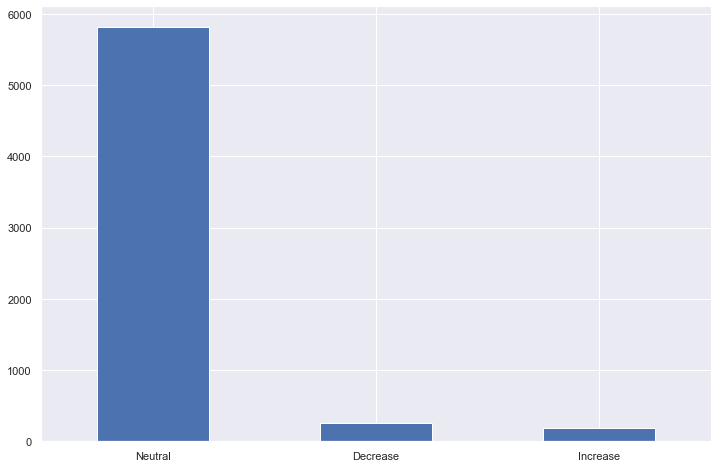

In [512]:
s1_changes_df['Max_Delta'].map(
    lambda x: 'Increase' if x>0 else('Decrease' if x <0 else 'Neutral')
).value_counts().plot(kind='bar', rot=0)

<AxesSubplot:>

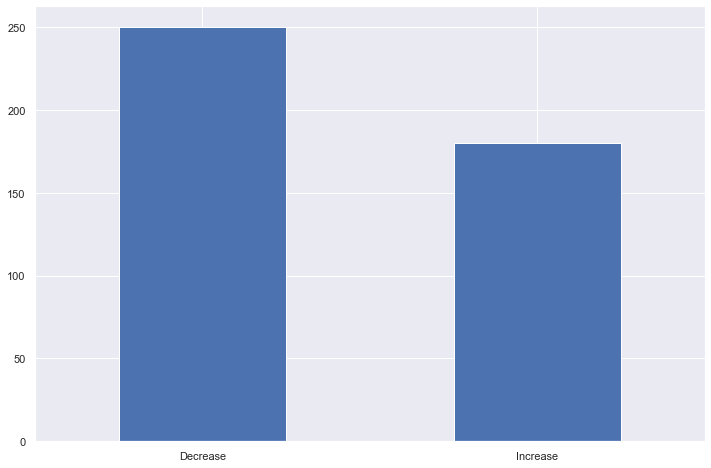

In [515]:
s1_sign_changes_df['Max_Delta'].map(
    lambda x: 'Increase' if x>0 else 'Decrease'
).value_counts().plot(kind='bar', rot=0)

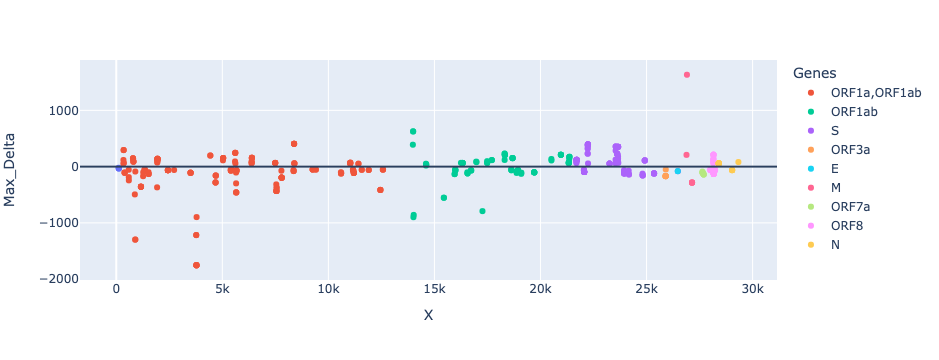

In [544]:
# Plot mutations effects annotated by genes
# for _, row in gene_annotations_df.iterrows():
#     fig.add_trace(
#         go.Scatter(
#             x=[row.thickStart, row.thickEnd],
#             y=[MAX_Y_VALUE*y, MAX_Y_VALUE*y],
#             name=row['name'],
#             fill='tozeroy',
#             opacity=0.01
#         )
    
fig = px.scatter(
    s1_sign_changes_df[s1_sign_changes_df['Max_Delta'].abs()<5000],
#     s1_sign_changes_df[s1_sign_changes_df['Max_Delta'] > -100000],
    x='X', y='Max_Delta', color='Genes')
# fig.write_html("significant_zscore_mutations.html")
fig.add_hline(y=0)

fig.show()

In [532]:
s1_sign_changes_df.to_csv('zscore_significant_mutations.csv')

In [536]:
print(aligned_s1_ref['NC_045512.2'][17230:17300]) # CoV 2
print(aligned_s1_ref['NC_004718.3'][17230:17300]) # SARS 1

TTAAAATATTTGCCTATAGATAAATGTAGTAGAATTATACCTGCACGTGCTCGTGTAGAGTGTTTTGATA
TTAAAATATTTGCCCATAGATAAATGTAGTAGAATCATACCTGCGCGTGCGCGCGTAGAGTGTTTTGATA


In [539]:
old_sars = ''
new_cov2 = ''
for old, new in zip(aligned_s1_ref['NC_045512.2'][17230:17300], aligned_s1_ref['NC_004718.3'][17230:17300]):
    if old == new:
        old_sars += old
        new_cov2 += new
    else:
        old_sars += old.lower()
        new_cov2 += new.lower()
print('SARS COV2: ', new_cov2) # CoV 2
print('SARS     : ', old_sars) # SARS 1

SARS COV2:  TTAAAATATTTGCCcATAGATAAATGTAGTAGAATcATACCTGCgCGTGCgCGcGTAGAGTGTTTTGATA
SARS     :  TTAAAATATTTGCCtATAGATAAATGTAGTAGAATtATACCTGCaCGTGCtCGtGTAGAGTGTTTTGATA


In [547]:
s1_sign_changes_df.sort_values('Max_Delta', ascending=True).iloc[:20]

,X,Type,Old_base,New_base,Target_strain,Max_r,Max_s1,Genes,Max_Delta
3674,17283,Change,C,T,Sars CoV 2,711.1420,383314.700,ORF1ab,-382603.5580
3673,17280,Change,G,T,Sars CoV 2,711.1420,383314.700,ORF1ab,-382603.5580
3672,17274,Change,G,A,Sars CoV 2,711.1420,383314.700,ORF1ab,-382603.5580
139,893,Change,C,T,Sars CoV 2,323.1150,32953.930,"ORF1a,ORF1ab",-32630.8150
138,890,Change,G,T,Sars CoV 2,323.1150,32953.930,"ORF1a,ORF1ab",-32630.8150
137,887,Change,C,T,Sars CoV 2,323.1150,32953.930,"ORF1a,ORF1ab",-32630.8150
136,881,Change,C,A,Sars CoV 2,159.9871,26195.480,"ORF1a,ORF1ab",-26035.4929
135,876,Change,T,C,Sars CoV 2,159.9871,10721.110,"ORF1a,ORF1ab",-10561.1229
413,1910,Change,T,C,Sars CoV 2,0.0000,6261.244,"ORF1a,ORF1ab",-6261.2440
415,1913,Change,G,C,Sars CoV 2,0.0000,6261.244,"ORF1a,ORF1ab",-6261.2440


In [559]:
COORD = 3780
DISTANCE = 100

old_sars = ''
new_cov2 = ''
for new, old in zip(aligned_s1_ref['NC_045512.2'][COORD-DISTANCE:COORD+DISTANCE],
                    aligned_s1_ref['NC_004718.3'][COORD-DISTANCE:COORD+DISTANCE]):
    if old == new:
        old_sars += old
        new_cov2 += new
    else:
        old_sars += old.lower()
        new_cov2 += new.lower()
        
with open(f'fold_sequences/{COORD}/NC_045512_{DISTANCE}.txt', 'w') as f:
    f.write(new_cov2)
with open(f'fold_sequences/{COORD}/NC_004718_{DISTANCE}.txt', 'w') as f:
    f.write(old_sars)


# Sequences count

In [573]:
# SARS 2003 Z-Score >= 300 sequences:
high_zscore_ranges_s1 = s1_ranges[s1_ranges.df['Z-Score']>=300].merge().df

high_zscore_ranges_s1['Length'] = high_zscore_ranges_s1['End'] - high_zscore_ranges_s1['Start']
high_zscore_ranges_s1.Length.sum()

265

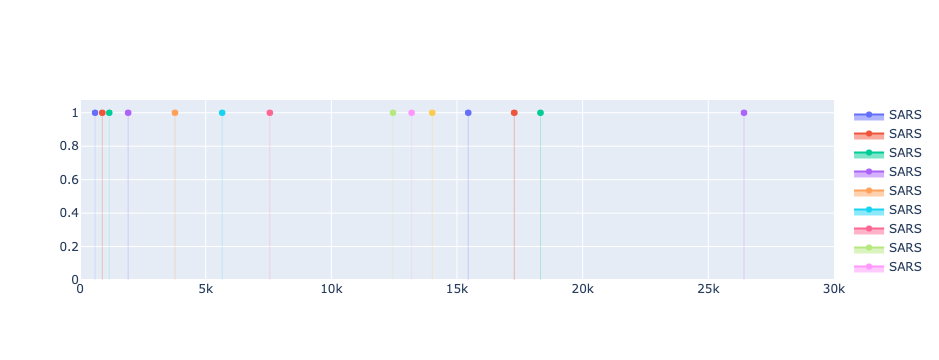

In [579]:
fig = go.Figure(layout_xaxis_range=[0,30000])
for _, row in high_zscore_ranges_s1.iterrows():
    fig.add_trace(
        go.Scatter(
            x=[row.Start, row.End],
            y=[1, 1],
            name='SARS',
            fill='tozeroy',
            opacity=0.01
        )
    )

fig.show()

In [574]:
# SARS CoV 2 Z-Score >= 300 sequences:

high_zscore_ranges_r = r_ranges[r_ranges.df['Z-Score']>=300].merge().df
high_zscore_ranges_r['Length'] = high_zscore_ranges_r['End'] - high_zscore_ranges_r['Start']
high_zscore_ranges_r.Length.sum()


209

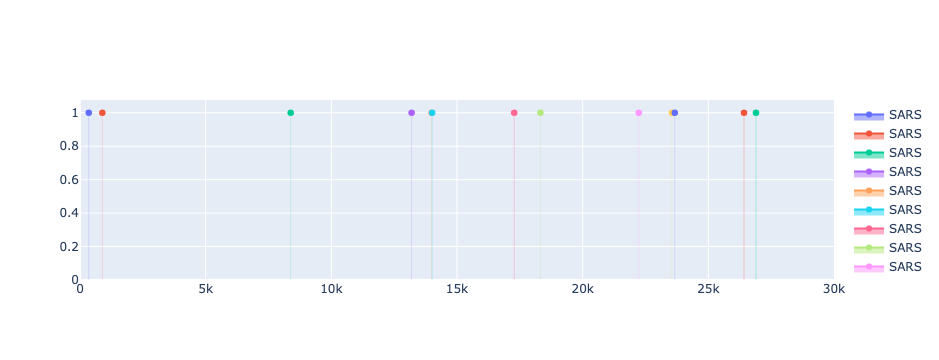

In [580]:
fig = go.Figure(layout_xaxis_range=[0,30000])
for _, row in high_zscore_ranges_r.iterrows():
    fig.add_trace(
        go.Scatter(
            x=[row.Start, row.End],
            y=[1, 1],
            name='SARS',
            fill='tozeroy',
            opacity=0.01
        )
    )

fig.show()

In [620]:
s1_ranges[s1_ranges.df['Z-Score']>=3000]

,Start,End,nu-1,nu-2,nu-3,Z-Score,Sequence,Conformation,Sequence_id,Strain,Chromosome
0,876,892,16,19.490,37.488,10721.110,ttttctcgcacgcgcg,ASASASASASASASAS,NC_004718.3,Sars1,chr1
1,878,894,16,19.226,39.773,15846.220,ttctcgcacgcgcggg,ASASASASASASASAS,NC_004718.3,Sars1,chr1
2,879,895,16,19.900,42.851,5956.111,tctcgcacgcgcgggc,SASASASASASASASA,NC_004718.3,Sars1,chr1
3,880,896,16,18.895,43.895,26195.480,ctcgcacgcgcgggca,ASASASASASASASAS,NC_004718.3,Sars1,chr1
4,881,895,14,19.711,42.548,7793.663,tcgcacgcgcgggc,SASASASASASASA,NC_004718.3,Sars1,chr1
5,882,896,14,18.746,43.344,32953.930,cgcacgcgcgggca,ASASASASASASAS,NC_004718.3,Sars1,chr1
6,883,895,12,19.557,41.245,9721.919,gcacgcgcgggc,SASASASASASA,NC_004718.3,Sars1,chr1
7,884,896,12,19.976,37.454,5351.021,cacgcgcgggca,ASASASASASAS,NC_004718.3,Sars1,chr1
8,1906,1922,16,20.364,34.995,3138.374,atttttgcgcgcacac,SASASASASASASASA,NC_004718.3,Sars1,chr1
9,1908,1922,14,20.114,35.822,4417.091,ttttgcgcgcacac,SASASASASASASA,NC_004718.3,Sars1,chr1


In [591]:
s1_seq = SeqIO.parse('data/sars_mers/sars2003.fasta', 'fasta')
sars_zdna_sequence = list(s1_seq)[0]

In [601]:
sars_zdna_sequence[17150:17200].seq.__str__()

'AAATGTAGTAGAATCATACCTGCGCGTGCGCGCGTAGAGTGTTTTGATAA'

In [625]:
'  '.join(sars_zdna_sequence[265:21485].translate().seq.__str__()[5717:5737])

'R  T  R  I  F  *  F  S  V  Q  T  Y  E  N  N  R  S  R  H  V'

In [622]:
ref_seq = SeqIO.parse('data/sars_mers/reference.fasta', 'fasta')
ref_zdna_sequence = list(ref_seq)[0]

In [628]:
ref_zdna_sequence[17260:17300].seq.__str__()

'GTTTTGATAAATTCAAAGTGAATTCAACATTAGAACAGTA'

In [629]:
'  '.join(ref_zdna_sequence[265:21555].translate().seq.__str__()[5748:5768])

'C  V  D  L  *  K  L  *  V  Q  T  C  S  S  E  L  V  G  V  V'

In [621]:
gene_annotations_df

,#chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,reserved,blockCount,...,geneName,geneName2,geneType,note,product,geneId,_cdnaSeq,_cdnaPsl,_protSeq,_protPsl
0,NC_045512v2,265,13483,ORF1a,0,+,265,13483,0,1,...,ORF1a,ORF1a,N.a.,pp1a,YP_009725295.1,43740578,ATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAAC...,NaN,"OrderedDict([('gene', ['ORF1ab']), ('locus_tag...",NaN
1,NC_045512v2,265,21555,ORF1ab,0,+,265,21555,0,2,...,ORF1ab,ORF1ab,N.a.,pp1ab; translated by -1 ribosomal frameshift,YP_009724389.1,43740578,ATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAAC...,NaN,"OrderedDict([('gene', ['ORF1ab']), ('locus_tag...",NaN
2,NC_045512v2,21562,25384,S,0,+,21562,25384,0,1,...,S,S,N.a.,structural protein; spike protein,YP_009724390.1,43740568,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,NaN,"OrderedDict([('gene', ['S']), ('locus_tag', ['...",NaN
3,NC_045512v2,25392,26220,ORF3a,0,+,25392,26220,0,1,...,ORF3a,ORF3a,N.a.,NaN,YP_009724391.1,43740569,ATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGA...,NaN,"OrderedDict([('gene', ['ORF3a']), ('locus_tag'...",NaN
4,NC_045512v2,26244,26472,E,0,+,26244,26472,0,1,...,E,E,N.a.,ORF4; structural protein; E protein,YP_009724392.1,43740570,ATGTACTCATTCGTTTCGGAAGAGACAGGTACGTTAATAGTTAATA...,NaN,"OrderedDict([('gene', ['E']), ('locus_tag', ['...",NaN
5,NC_045512v2,26522,27191,M,0,+,26522,27191,0,1,...,M,M,N.a.,ORF5; structural protein,YP_009724393.1,43740571,ATGGCAGATTCCAACGGTACTATTACCGTTGAAGAGCTTAAAAAGC...,NaN,"OrderedDict([('gene', ['M']), ('locus_tag', ['...",NaN
6,NC_045512v2,27201,27387,ORF6,0,+,27201,27387,0,1,...,ORF6,ORF6,N.a.,NaN,YP_009724394.1,43740572,ATGTTTCATCTCGTTGACTTTCAGGTTACTATAGCAGAGATATTAC...,NaN,"OrderedDict([('gene', ['ORF6']), ('locus_tag',...",NaN
7,NC_045512v2,27393,27759,ORF7a,0,+,27393,27759,0,1,...,ORF7a,ORF7a,N.a.,NaN,YP_009724395.1,43740573,ATGAAAATTATTCTTTTCTTGGCACTGATAACACTCGCTACTTGTG...,NaN,"OrderedDict([('gene', ['ORF7a']), ('locus_tag'...",NaN
8,NC_045512v2,27755,27887,ORF7b,0,+,27755,27887,0,1,...,ORF7b,ORF7b,N.a.,NaN,YP_009725318.1,43740574,ATGATTGAACTTTCATTAATTGACTTCTATTTGTGCTTTTTAGCCT...,NaN,"OrderedDict([('gene', ['ORF7b']), ('locus_tag'...",NaN
9,NC_045512v2,27893,28259,ORF8,0,+,27893,28259,0,1,...,ORF8,ORF8,N.a.,NaN,YP_009724396.1,43740577,ATGAAATTTCTTGTTTTCTTAGGAATCATCACAACTGTAGCTGCAT...,NaN,"OrderedDict([('gene', ['ORF8']), ('locus_tag',...",NaN
